In [1]:
import skrub
from sklearn.ensemble import HistGradientBoostingClassifier
from skrub import TableVectorizer

import sempipes

dataset = skrub.datasets.fetch_midwest_survey()
X = dataset.X.head(n=500)
y = dataset.y.head(n=500)

responses = skrub.var("response", X)
responses = responses.skb.set_description(dataset.metadata["description"])

labels = skrub.var("labels", y)
labels = labels.skb.set_name(dataset.metadata["target"])

responses = responses.skb.mark_as_X()
labels = labels.skb.mark_as_y()

responses_with_additional_features = responses.with_sem_features(
    nl_prompt="""
        Compute additional demographics-related features, use your intrinsic knowledge about the US. 
        Take into account how the identification with the country or regions of it changed over the generations.         
        Also think about how the identification differs per class and education. The midwest is generally associated 
        with "Midwestern values" — friendliness, modesty, hard work, and community-mindedness.
    """,
    name="demographic_features",
    how_many=5,
)

feature_encoder = TableVectorizer()
encoded_responses = responses_with_additional_features.skb.apply(feature_encoder)

learner = HistGradientBoostingClassifier()
model = encoded_responses.skb.apply(learner, y=labels)

	> Querying 'openai/gpt-4.1' with 2 messages...'
	> Computed 5 new feature columns: ['age_group', 'education_level', 'income_bracket', 'is_midwest_resident', 'midwest_identity_score'], removed 0 feature columns: []


In [2]:
from sempipes.optimisers.search_policy import TreeSearch

sempipes.set_config(
    sempipes.Config(
        llm_for_code_generation=sempipes.LLM(
            name="gemini/gemini-2.5-flash",
            parameters={"temperature": 0.3},
        ),
        llm_for_batch_processing=sempipes.LLM(
            name="ollama/gemma3:1b",
            parameters={"api_base": "http://localhost:11434", "temperature": 0.0},
        ),
    )
)

# Note that this should be done on a separate validation set in a real world use case
outcomes = sempipes.optimise_olopro(
    model, "demographic_features", budget=12, scoring="accuracy", cv=5, search=TreeSearch(min_num_drafts=2)
)

	OLOPRO> Computing pipeline summary for context-aware optimisation ---
	TREE_SEARCH> Creating root node
	OLOPRO> Processing trial 0
	OLOPRO> Fitting pipeline
	OLOPRO> Evaluating pipeline via 5-fold cross-validation
	OLOPRO> Score changed to 0.764
	TREE_SEARCH> Drafting new node
	OLOPRO> Processing trial 1
	OLOPRO> Fitting pipeline
	> Querying 'gemini/gemini-2.5-flash' with 4 messages...'
	> Computed 5 new feature columns: ['age_group_ordinal', 'borderline_midwest_states_recognized', 'core_midwest_states_recognized', 'is_self_identified_midwesterner', 'personal_midwestern_identification_score'], removed 0 feature columns: []
	OLOPRO> Evaluating pipeline via 5-fold cross-validation
	OLOPRO> Score changed to 0.79
	TREE_SEARCH> Drafting new node
	OLOPRO> Processing trial 2
	OLOPRO> Fitting pipeline
	> Querying 'gemini/gemini-2.5-flash' with 4 messages...'
	> Computed 5 new feature columns: ['age_numeric', 'education_numeric', 'midwest_border_states_count', 'midwest_core_states_count', 'per

In [6]:
best_outcome = max(outcomes, key=lambda x: x.score)
best_outcome.score

0.916

In [7]:
print("\n".join(best_outcome.state["generated_code"]))


# (is_self_identified_midwesterner)
# Usefulness: Directly captures self-identification with the region, which is a strong indicator for "Census_Region". Cleaning the text ensures consistency across various spellings.
# Input samples: 'What_would_you_call_the_part_of_the_country_you_live_in_now': ['Southern', 'Midwest', 'Mid-west', 'midewest', 'Midwest', 'Midwest', 'Mid west', 'The Upper Midwest', 'East Coast', 'South Central']
df['is_self_identified_midwesterner'] = df['What_would_you_call_the_part_of_the_country_you_live_in_now'].str.lower().str.contains('midwest|mid-west|mid west').astype(int)

# (personal_midwestern_identification_score)
# Usefulness: Converts a categorical ordinal feature into a numerical one, allowing the model to capture the strength of identification. This is crucial for understanding how "Midwestern values" might correlate with identification.
# Input samples: 'How_much_do_you_personally_identify_as_a_Midwesterner': ['Not much', 'Not much', 'A lot', 'A lot', 

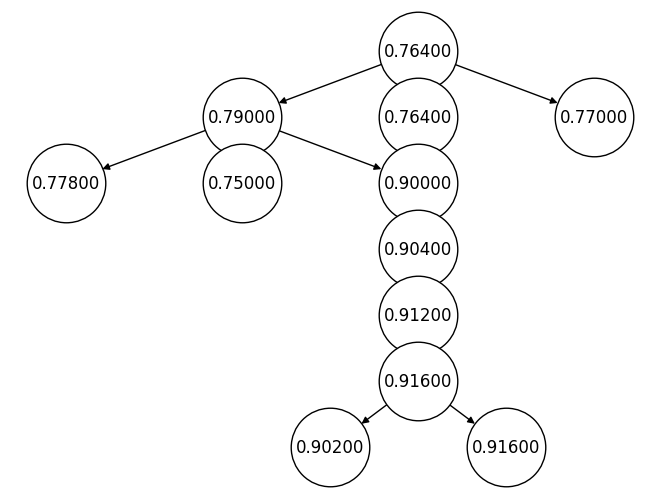

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

attributes = {}
edges = []

for outcome in outcomes:
    node_id = id(outcome.search_node)
    if outcome.search_node.parent is not None:
        parent_node_id = id(outcome.search_node.parent)
        edges.append((parent_node_id, node_id))
    attributes[node_id] = {"score": f"{outcome.score:.5f}"}

G = nx.DiGraph()
G.add_edges_from(edges)
nx.set_node_attributes(G, attributes)

labels = nx.get_node_attributes(G, "score")
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")

nx.draw(
    G,
    pos,
    with_labels=True,
    labels=labels,
    arrows=True,
    node_size=3200,
    node_color="white",
    edgecolors="black",
)
plt.show()